# COVID-19 Detection using Chest X-rays

The exponential increase in COVID-19 patients is overwhelming the healthcare systems across the world and it continues to have a devastating effect on the population. A critical step in the fight against the virus is a fast and reliable testing technique. The conventional techniques (RT-PCR) is costly and more importantly they take time and have limited sensitivity.

![alt text](https://images.indianexpress.com/2020/03/Coronavirus_AI_tool.jpg)

*Source: Indian Express*

While the diagnosis is confirmed using polymerase chain reaction (PCR), infected patients with pneumonia may present on chest X-ray and computed tomography (CT) images with a pattern that is only moderately characteristic for the human eye. In late January, a Chinese team published a paper detailing the clinical and paraclinical features of COVID-19. They reported that patients present abnormalities in chest CT images with most having bilateral involvement.

Detecting possible COVID-19 infection from Chest X-ray will provide a faster and reliable method that could be used with the conventional tests for faster detection. Since most modern healthcare systems are equipped with digitized X-ray machines, there are no additional costs or resources required for testing.

### Importing Libraries

In [0]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import os
from imutils import paths

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub

## Getting the Data

The training images used in the model are sourced from The University of Montreal. It has been sorted and structured and is shared in Kaggle by Pranav Raikote https://www.kaggle.com/pranavraikokte/covid19-image-dataset

### Loading the Data

In [0]:
# We use the zip file downloaded from the link above and upload it to Google Drive

PATH_TO_ZIP = "/content/drive/My Drive/Data for Colab/covid19-image-dataset.zip" # replace this line with the path to your zip file
zip_ref = zipfile.ZipFile(PATH_TO_ZIP, "r")
zip_ref.extractall("/tmp")
zip_ref.close()

In [0]:
# Create a path to the train and test directory

DATA_PATH = "/tmp/Covid19-dataset"
train_dir = os.path.join(DATA_PATH, 'train')
test_dir = os.path.join(DATA_PATH, 'test')

In [0]:
# Create paths to the different classes of the data

train_normal_dir = os.path.join(train_dir, 'Normal')
train_covid_dir = os.path.join(train_dir, 'Covid')
train_pneumonia_dir = os.path.join(train_dir, 'Viral Pneumonia')

test_normal_dir = os.path.join(test_dir, 'Normal')
test_covid_dir = os.path.join(test_dir, 'Covid')
test_pneumonia_dir = os.path.join(test_dir, 'Viral Pneumonia')

In [5]:
# Print the details about the loaded data

print('Total training Covid Images:', len(os.listdir(train_covid_dir)))
print('Total training Normal Images:', len(os.listdir(train_normal_dir)))
print('Total training Viral Pneumonia Images:', len(os.listdir(train_pneumonia_dir)))

print('Total test Covid Images:', len(os.listdir(test_covid_dir)))
print('Total test Normal Images:', len(os.listdir(test_normal_dir)))
print('Total test Viral Pneumonia Images:', len(os.listdir(test_pneumonia_dir)))

Total training Covid Images: 111
Total training Normal Images: 70
Total training Viral Pneumonia Images: 70
Total test Covid Images: 26
Total test Normal Images: 20
Total test Viral Pneumonia Images: 20


As shown above the data consists of 3 categories. i.e 3 types of Chest X-rays:


*   Normal
*   COVID-19 affected
*   Affected with Viral Pneumonia



## Preprocessing the Images

Before passing the image to the model, we first preprocess the the images.

In [0]:
# Setup the variables

batch_size = 20
epochs = 30
IMG_HEIGHT = 640
IMG_WIDTH = 640

In [0]:
# Rescale the tensors from values between 0 and 255 to values between 0 and 1

image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    horizontal_flip=True,
                    )

image_gen_val = ImageDataGenerator(rescale=1./255)

In [8]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=test_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


Now, we can take a look at our preprocessed images.

In [0]:
# Plot some sample images

sample_training_images, _ = next(train_data_gen)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

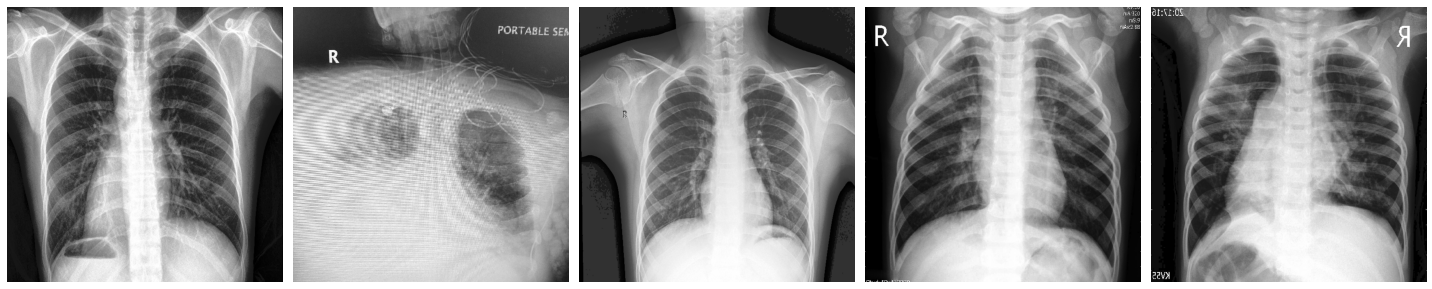

In [10]:
plotImages(sample_training_images[:5])

## Creating the model

We use the transfer learning aproach to build our model on top of the VGG16 model which has been pre-trained. 

On top of the model we add sequential layers and train the model with our data.

Learn more about VGG16 model: https://keras.io/api/applications/vgg/#vgg16-function

![alt text](https://miro.medium.com/max/470/1*3-TqqkRQ4rWLOMX-gvkYwA.png)

*source: Towards Data Science*

In [0]:
# Loading VGG16 base model from Keras

baseModel = tf.keras.applications.VGG16(weights="imagenet", 
                                        include_top=False, 
                                        input_tensor=tf.keras.layers.Input(shape=(640, 640, 3)))
baseModel.trainable = False

In [0]:
# Add more layers to the base model

model = tf.keras.models.Sequential()

model.add(baseModel)

model.add(tf.keras.layers.AveragePooling2D(pool_size=(4,4)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation="softmax"))

In [13]:
# Compile the model

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 20, 20, 512)       14714688  
_________________________________________________________________
average_pooling2d (AveragePo (None, 5, 5, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                819264    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 15,534,147
Trainable params: 819,459
Non-trainable params: 14,714,688
______________________________________

## Training the model

We train the model and we validate the trained model and see how it performs

In [14]:
# Fit the model with the train and validation data

history = model.fit(
    train_data_gen,
    steps_per_epoch = 12, 
    epochs = epochs,
    validation_data = val_data_gen,
    validation_steps = 3 
)

Epoch 1/30
12/12 [==============================] - 32s 3s/step - loss: 1.4586 - accuracy: 0.4242 - val_loss: 1.0222 - val_accuracy: 0.4333
Epoch 2/30
12/12 [==============================] - 27s 2s/step - loss: 0.9783 - accuracy: 0.4167 - val_loss: 0.8442 - val_accuracy: 0.6333
Epoch 3/30
12/12 [==============================] - 27s 2s/step - loss: 0.8827 - accuracy: 0.5238 - val_loss: 0.7061 - val_accuracy: 0.7500
Epoch 4/30
12/12 [==============================] - 26s 2s/step - loss: 0.8272 - accuracy: 0.5887 - val_loss: 0.7402 - val_accuracy: 0.7000
Epoch 5/30
12/12 [==============================] - 26s 2s/step - loss: 0.7615 - accuracy: 0.5801 - val_loss: 0.6275 - val_accuracy: 0.7167
Epoch 6/30
12/12 [==============================] - 26s 2s/step - loss: 0.6983 - accuracy: 0.6450 - val_loss: 0.5742 - val_accuracy: 0.7500
Epoch 7/30
12/12 [==============================] - 26s 2s/step - loss: 0.6847 - accuracy: 0.5931 - val_loss: 0.5203 - val_accuracy: 0.7500
Epoch 8/30
12/12 [==

In [0]:
# Training results

train_acc = history.history["accuracy"]
train_loss = history.history["loss"]

validation_acc = history.history["val_accuracy"]
validation_loss = history.history["val_loss"]

epochs = range(len(train_acc))

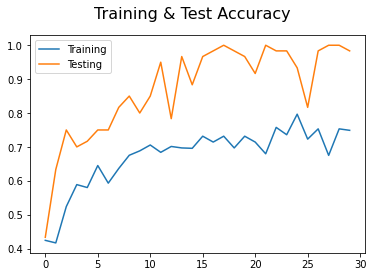

In [16]:
# Plot the train and test accuracy

fig, ax = plt.subplots()
ax.plot(epochs, train_acc, label='Training')
ax.plot(epochs, validation_acc, label='Testing')
leg = ax.legend();
fig.suptitle('Training & Test Accuracy', fontsize=16);

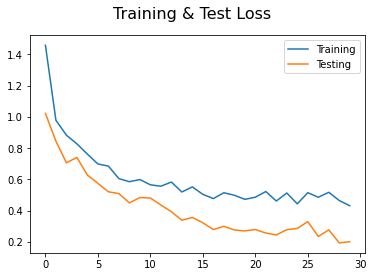

In [17]:
# Plot the train and test loss

fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label='Training')
ax.plot(epochs, validation_loss, label='Testing')
leg = ax.legend();
fig.suptitle('Training & Test Loss', fontsize=16);

## Results

As from the plot above, our model is performing very well with close to a perfect score, i.e 100% accuracy with the given data.

This result implies that this is a very good approach for detecting possible COVID-19 infections. The model is very accurate and with even more data, the model will be able to perform extremely well in the current scenario.

Feel free to use this model!

## References

https://arxiv.org/abs/2004.09803

https://github.com/lindawangg/COVID-Net

https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30183-5/fulltext#seccestitle10

https://github.com/ieee8023/covid-chestxray-dataset